# NOAA AVHRR Image Georeferencing and Rotation
This notebook demonstrates how to georeference an AVHRR-2 image from NOAA using its orbital metrics

### Install required packages

In [1]:
!pip install geodatasets pyorbital cbor2 rasterio pillow geopandas matplotlib skyfield

In [2]:
import cbor2
import rasterio
import geodatasets
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from PIL import Image
from pyproj import Geod
from datetime import datetime
from pyorbital.orbital import Orbital
from rasterio.transform import from_bounds
from scipy.ndimage import rotate
from datetime import datetime, timezone
from math import radians, tan
from skyfield.api import EarthSatellite, load
from datetime import datetime, timezone
from math import radians, tan
from skyfield.api import EarthSatellite, load
from rasterio.transform import from_origin
from scipy.interpolate import griddata

In [3]:
# Read CBOR file
with open("data/2025-07-11_05-39_noaa_apt_137MHz/product.cbor", "rb") as f:
    product = cbor2.load(f)

geod = Geod(ellps='WGS84')

def compute_product_metrics(product: dict) -> dict:
    """
    Compute accurate satellite image metrics with proper corner coordinates,
    along-track and across-track distances, to fix FOV misalignment.
    """
    proj = product.get('projection_cfg', {})
    image_width = int(proj.get('image_width'))
    timestamps = product.get('timestamps', [])
    image_height = len(timestamps)
    if image_height == 0:
        raise ValueError("No timestamps found")
    
    mid_ts = 0.5 * (timestamps[0] + timestamps[-1])
    mid_datetime = datetime.fromtimestamp(mid_ts, tz=timezone.utc)
    
    tle = product.get('tle', {})
    line1 = tle.get('line1')
    line2 = tle.get('line2')
    name = tle.get('name', 'sat')
    if not line1 or not line2:
        raise ValueError("TLE lines missing")
    
    sat = EarthSatellite(line1, line2, name)
    ts_sf = load.timescale()
    
    def to_sf_time(posix_ts):
        dt = datetime.fromtimestamp(posix_ts, tz=timezone.utc)
        return ts_sf.utc(dt.year, dt.month, dt.day,
                         dt.hour, dt.minute, dt.second + dt.microsecond/1e6)
    
    # Subpoints
    sub_first = sat.at(to_sf_time(timestamps[0])).subpoint()
    sub_mid   = sat.at(to_sf_time(mid_ts)).subpoint()
    sub_last  = sat.at(to_sf_time(timestamps[-1])).subpoint()
    
    # Scan angle / FOV
    scan_angle_deg = proj.get('scan_angle', 0.0)
    half_angle_rad = radians(scan_angle_deg / 2.0)
    
    # --- Along-track distance ---
    fwd_az, back_az, along_track_length_m = geod.inv(
        sub_first.longitude.degrees, sub_first.latitude.degrees,
        sub_last.longitude.degrees, sub_last.latitude.degrees
    )
    pix_along_m = along_track_length_m / image_height
    along_track_length_km = along_track_length_m / 1000.0
    
    # --- Across-track distance ---
    swath_radius_m = sub_mid.elevation.km * 1000.0 * tan(half_angle_rad)
    
    def corner_offset(lat, lon, azimuth_deg, distance_m):
        lon2, lat2, _ = geod.fwd(lon, lat, azimuth_deg, distance_m)
        return lat2, lon2
    
    # Perpendicular azimuths
    perp_left = (fwd_az - 90) % 360
    perp_right = (fwd_az + 90) % 360
    
    # Top corners at mid-track
    top_left = corner_offset(sub_mid.latitude.degrees, sub_mid.longitude.degrees, perp_left, swath_radius_m)
    top_right = corner_offset(sub_mid.latitude.degrees, sub_mid.longitude.degrees, perp_right, swath_radius_m)
    
    # Move along-track to get bottom corners
    half_along_m = along_track_length_m / 2.0
    bottom_left = corner_offset(top_left[0], top_left[1], fwd_az + 180, half_along_m)
    bottom_right = corner_offset(top_right[0], top_right[1], fwd_az + 180, half_along_m)
    
    # --- Compute across-track swath properly ---
    lons_across = [top_left[1], top_right[1]]
    lats_across = [top_left[0], top_right[0]]
    across_track_swath_km = geod.line_length(lons_across, lats_across) / 1000.0
    pix_across_m = (across_track_swath_km * 1000.0) / image_width
    
    total_area_km2 = along_track_length_km * across_track_swath_km
    per_pixel_area_km2 = (pix_along_m * pix_across_m) / 1e6
    
    metrics = {
        "image_width_px": image_width,
        "image_height_px": image_height,
        "mid_datetime": mid_datetime.isoformat(),
        "mid_subpoint": {
            "lat_deg": float(sub_mid.latitude.degrees),
            "lon_deg": float(sub_mid.longitude.degrees),
            "alt_km": float(sub_mid.elevation.km)
        },
        "first_subpoint": {
            "lat_deg": float(sub_first.latitude.degrees),
            "lon_deg": float(sub_first.longitude.degrees)
        },
        "last_subpoint": {
            "lat_deg": float(sub_last.latitude.degrees),
            "lon_deg": float(sub_last.longitude.degrees)
        },
        "corner_top_left": {"lat_deg": top_left[0], "lon_deg": top_left[1]},
        "corner_top_right": {"lat_deg": top_right[0], "lon_deg": top_right[1]},
        "corner_bottom_left": {"lat_deg": bottom_left[0], "lon_deg": bottom_left[1]},
        "corner_bottom_right": {"lat_deg": bottom_right[0], "lon_deg": bottom_right[1]},
        "along_track_length_km": along_track_length_km,
        "along_track_pixel_size_m": pix_along_m,
        "across_track_swath_km": across_track_swath_km,
        "across_track_pixel_size_m": pix_across_m,
        "total_ground_area_km2": total_area_km2,
        "per_pixel_area_km2": per_pixel_area_km2,
        "fov_deg": float(scan_angle_deg)
    }
    
    return metrics
    

metrics = compute_product_metrics(product)
metrics

{'image_width_px': 909,
 'image_height_px': 860,
 'mid_datetime': '2025-07-11T05:46:46.750000+00:00',
 'mid_subpoint': {'lat_deg': -19.29353525433381,
  'lon_deg': 57.87016861985247,
  'alt_km': 852.79286718039},
 'first_subpoint': {'lat_deg': -6.751092775383772,
  'lon_deg': 60.85698089118781},
 'last_subpoint': {'lat_deg': -31.789096873340295,
  'lon_deg': 54.53467310349489},
 'corner_top_left': {'lat_deg': -21.330160040661813,
  'lon_deg': 69.46649740177457},
 'corner_top_right': {'lat_deg': -16.541784606199823,
  'lon_deg': 46.60424211567302},
 'corner_bottom_left': {'lat_deg': -8.744001842683158,
  'lon_deg': 72.25242665479571},
 'corner_bottom_right': {'lat_deg': -3.956791225031293,
  'lon_deg': 49.36450978232331},
 'along_track_length_km': 2848.7940361443457,
 'along_track_pixel_size_m': 3312.551204819006,
 'across_track_swath_km': 2463.178614823464,
 'across_track_pixel_size_m': 2709.767453051116,
 'total_ground_area_km2': 7017088.547867375,
 'per_pixel_area_km2': 8.97624344138

/tmp/ipykernel_1444/411318698.py:51: RuntimeWarning: invalid value encountered in cast
  img_resampled[b] = griddata(


GeoTIFF saved: AVHRR-2-Georeferenced.tif


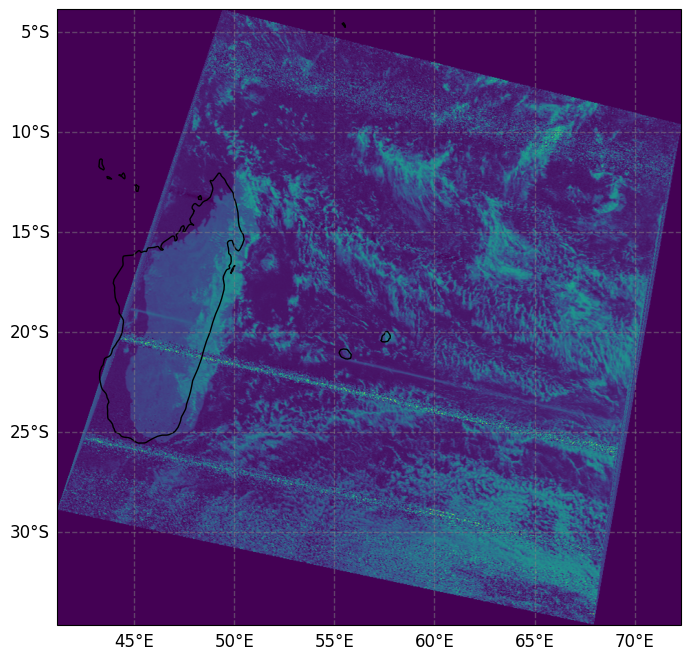

In [4]:
import numpy as np
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load image
img = np.array(Image.open("data/2025-07-11_05-39_noaa_apt_137MHz/AVHRR-2.png"))
height, width = img.shape[:2]

# Satellite metrics
metrics = metrics

# Along-track interpolation
along_lats = np.linspace(metrics['first_subpoint']['lat_deg'],
                         metrics['last_subpoint']['lat_deg'], height)
along_lons = np.linspace(metrics['first_subpoint']['lon_deg'],
                         metrics['last_subpoint']['lon_deg'], height)

# Track and perpendicular angles
delta_lat = metrics['last_subpoint']['lat_deg'] - metrics['first_subpoint']['lat_deg']
delta_lon = metrics['last_subpoint']['lon_deg'] - metrics['first_subpoint']['lon_deg']
track_angle = np.arctan2(delta_lat, delta_lon)
perp_angle = track_angle + np.pi / 2

# Across-track offsets
mean_lat = np.mean([metrics['first_subpoint']['lat_deg'], metrics['last_subpoint']['lat_deg']])
km_per_deg_lon = 111 * np.cos(np.radians(mean_lat))
swath_half_deg = (metrics['across_track_swath_km'] / km_per_deg_lon) / 2
across_offsets = np.linspace(-swath_half_deg, swath_half_deg, width)

# Build lat/lon grid
cos_lat = np.cos(np.radians(along_lats))[:, None]
lats_grid = along_lats[:, None] + across_offsets * np.sin(perp_angle)
lons_grid = along_lons[:, None] + (across_offsets * np.cos(perp_angle)) / cos_lat

# Interpolate onto regular grid for GeoTIFF
lat_target = np.linspace(lats_grid.min(), lats_grid.max(), height)
lon_target = np.linspace(lons_grid.min(), lons_grid.max(), width)
lon_target_2d, lat_target_2d = np.meshgrid(lon_target, lat_target)

if img.ndim == 2:
    img = img[np.newaxis, :, :]
else:
    img = img.transpose(2,0,1)

img_resampled = np.zeros((img.shape[0], height, width), dtype=img.dtype)
for b in range(img.shape[0]):
    img_resampled[b] = griddata(
        points=(lons_grid.flatten(), lats_grid.flatten()),
        values=img[b].flatten(),
        xi=(lon_target_2d, lat_target_2d),
        method='linear'
    )

# Flip vertically for GeoTIFF convention
img_resampled = img_resampled[:, ::-1, :]

# Save GeoTIFF
transform = from_origin(
    west=lon_target.min(),
    north=lat_target.max(),
    xsize=(lon_target.max()-lon_target.min())/(width-1),
    ysize=(lat_target.max()-lat_target.min())/(height-1)
)

out_path = "AVHRR-2-Georeferenced.tif"
with rasterio.open(
    out_path, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=img_resampled.shape[0],
    dtype=img_resampled.dtype,
    crs='EPSG:4326',
    transform=transform
) as dst:
    dst.write(img_resampled)

print(f"GeoTIFF saved: {out_path}")

# Plot exactly what is saved
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':12}
gl.ylabel_style = {'size':12}

img_plot = img_resampled.transpose(1,2,0)
ax.imshow(img_plot,
          extent=[lon_target.min(), lon_target.max(), lat_target.min(), lat_target.max()],
          origin='upper',
          transform=ccrs.PlateCarree())
plt.show()


/tmp/ipykernel_1444/661332825.py:53: RuntimeWarning: invalid value encountered in cast
  img_resampled[b] = griddata(


GeoTIFF saved: AVHRR-2-Georeferenced.tif


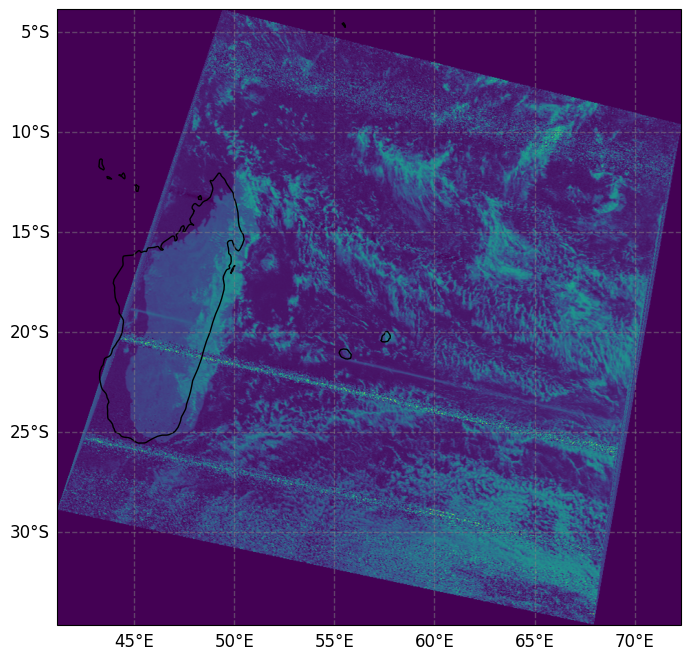

In [5]:
import numpy as np
from PIL import Image
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load image
img = np.array(Image.open("data/2025-07-11_05-39_noaa_apt_137MHz/AVHRR-2.png"))
height, width = img.shape[:2]

# Satellite metrics
# Use your existing `metrics` dictionary directly

# Along-track interpolation
along_lats = np.linspace(metrics['first_subpoint']['lat_deg'],
                         metrics['last_subpoint']['lat_deg'], height)
along_lons = np.linspace(metrics['first_subpoint']['lon_deg'],
                         metrics['last_subpoint']['lon_deg'], height)

# Track and perpendicular angles
delta_lat = metrics['last_subpoint']['lat_deg'] - metrics['first_subpoint']['lat_deg']
delta_lon = metrics['last_subpoint']['lon_deg'] - metrics['first_subpoint']['lon_deg']
track_angle = np.arctan2(delta_lat, delta_lon)
perp_angle = track_angle + np.pi / 2

# Across-track offsets
mean_lat = np.mean([metrics['first_subpoint']['lat_deg'], metrics['last_subpoint']['lat_deg']])
km_per_deg_lon = 111 * np.cos(np.radians(mean_lat))
swath_half_deg = metrics['across_track_swath_km'] / (2 * km_per_deg_lon)
across_offsets = np.linspace(-swath_half_deg, swath_half_deg, width)

# Build lat/lon grid
cos_lat = np.cos(np.radians(along_lats))[:, None]
lats_grid = along_lats[:, None] + across_offsets * np.sin(perp_angle)
lons_grid = along_lons[:, None] + (across_offsets * np.cos(perp_angle)) / cos_lat

# Interpolate onto regular grid for GeoTIFF
lat_target = np.linspace(lats_grid.min(), lats_grid.max(), height)
lon_target = np.linspace(lons_grid.min(), lons_grid.max(), width)
lon_target_2d, lat_target_2d = np.meshgrid(lon_target, lat_target)

# Ensure image has shape (bands, height, width)
if img.ndim == 2:
    img = img[np.newaxis, :, :]
else:
    img = img.transpose(2,0,1)

# Resample each band
img_resampled = np.zeros((img.shape[0], height, width), dtype=img.dtype)
for b in range(img.shape[0]):
    img_resampled[b] = griddata(
        points=(lons_grid.flatten(), lats_grid.flatten()),
        values=img[b].flatten(),
        xi=(lon_target_2d, lat_target_2d),
        method='linear'
    )

# Flip vertically for GeoTIFF convention
img_resampled = img_resampled[:, ::-1, :]

# Save GeoTIFF
transform = from_origin(
    west=lon_target.min(),
    north=lat_target.max(),
    xsize=(lon_target.max() - lon_target.min()) / (width - 1),
    ysize=(lat_target.max() - lat_target.min()) / (height - 1)
)

out_path = "AVHRR-2-Georeferenced.tif"
with rasterio.open(
    out_path, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=img_resampled.shape[0],
    dtype=img_resampled.dtype,
    crs='EPSG:4326',
    transform=transform
) as dst:
    dst.write(img_resampled)

print(f"GeoTIFF saved: {out_path}")

# Plot 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size':12}
gl.ylabel_style = {'size':12}

ax.imshow(
    img_resampled.transpose(1,2,0),
    extent=[lon_target.min(), lon_target.max(), lat_target.min(), lat_target.max()],
    origin='upper',
    transform=ccrs.PlateCarree()
)
plt.show()
